# Indicators to Vulnerability Index

## Environment

### R Libraries
The relvant R libraries are imported in to the kernal:

In [1]:
# Load R libraries
 if(!require("pacman"))
     install.packages("pacman")
     library("pacman")

p_load("sf","tidyverse")

print("Loaded Packages:")
p_loaded()

Loading required package: pacman



[1] "Loaded Packages:"


[1] "lubridate" "forcats"   "stringr"   "dplyr"     "purrr"     "readr"    
 [7] "tidyr"     "tibble"    "ggplot2"   "tidyverse" "sf"        "pacman"

### Output directory

In [2]:
# create the output directory if it does not exist
outputDir <- file.path("../..","3_outputs","Milan","2021")
if(!dir.exists(outputDir)){
    dir.create(outputDir, recursive = TRUE)
    print(paste0(outputDir, " created"))
}

### Set the GUID

In [3]:
GUID <- "SEZ2011"

## Load Data

### Import the data

In [4]:
# Load census data
censusIndicatorData <- read.csv("../../2_pipeline/Milan/1a_CensusData/2021/censusDataZ.csv")
head(censusIndicatorData)

# Load Coperncius data: tree cover density (TCD) and imperviousness density (IMP)
tcdIndicatorData <- st_read("../../2_pipeline/Milan/1b_Copernicus/2021/oa_TCD.geojson")
imdIndicatorData <- st_read("../../2_pipeline/Milan/1b_Copernicus/2021/oa_IMD.geojson")

# Get the geospatial data from the TCS data (the IMD data also has same spatial data)
oa <- subset(tcdIndicatorData, select = c(GUID, 'geometry'))

# Load vulnerability mapping information from the config file
## This mapping information is used to help guide the amalgamation of the data.
## Weighting can be changed in this file, depending on the scenario.
## Scenario 1 (best case scenario): Weighting values 1 or -1:
##  where 1 means no change
##  or -1 means all the indicator values are multiplied by -1, resulting in an inverse indicator.
## Scenario 2: Weighting values 0.5 or -0.5:
##  For domains with just a single indicators or where there is a lack of information related to missing indicators. 
##  For these domains the weights are halved using a weight of 0.5, or -0.5 for an inverse indicator.
##  Therefore the influence of these indicators are reduced in half.
## Other scenarios are supported by using other decimal numbers if decided for a particular dataset.
indicatorMapping <- read.csv("config/vulnerabilityIndicatorMappings.csv", header=TRUE, sep=",", stringsAsFactors = FALSE, fileEncoding="UTF-8-BOM")

# Print up to 100 rows of vulnerabiltiy mapping config file
head(indicatorMapping,100)

,SEZ2011,youngMale,youngFemale,oldMale,oldFemale,dependantsRate,unemployed,noHigherEductation,foreignNationals,primarySchool,onePersonHousehold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.5146e+11,-1.230411,-1.064144,2.1196292,-1.3062152,-0.7801407,-0.5060886,-0.6075338,0.284861877,-1.458348,0.9333249
2,1.5146e+11,-1.230411,-1.064144,0.2302043,-0.3189938,0.1197864,1.3419462,0.8849880,0.768744204,-1.458348,-0.7026211
3,1.5146e+11,-1.230411,-1.064144,3.8043177,-1.3062152,-2.2200240,-0.2425543,-1.6458099,-1.081394102,-1.458348,3.2236494
4,1.5146e+11,-1.230411,-1.064144,2.6982091,-1.3062152,-0.5183437,-1.2391934,-1.6458099,-0.004949997,1.865648,0.2789465
5,1.5146e+11,-1.230411,-1.064144,19.6216703,-1.3062152,-2.2200240,-2.2981224,-1.6458099,-1.081394102,-1.458348,3.2236494
6,1.5146e+11,-1.230411,-1.064144,-1.0625601,-1.3062152,-2.2200240,-2.2981224,-1.6458099,2.865567617,-1.458348,0.9333249


Reading layer `oa_TCD' from data source 
  `/Cities/2_pipeline/Milan/1b_Copernicus/2021/oa_TCD.geojson' 
  using driver `GeoJSON'
Simple feature collection with 6079 features and 15 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1503202 ymin: 5025952 xmax: 1521750 ymax: 5042528
Projected CRS: Monte Mario / Italy zone 1
Reading layer `oa_IMD' from data source 
  `/Cities/2_pipeline/Milan/1b_Copernicus/2021/oa_IMD.geojson' 
  using driver `GeoJSON'
Simple feature collection with 6079 features and 15 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 1503202 ymin: 5025952 xmax: 1521750 ymax: 5042528
Projected CRS: Monte Mario / Italy zone 1


,domain,indicator,sens,prepare,respond,recover,adaptiveCapacity,enhExp,weight
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,age,youngMale,1,0,0,0,0,0,1.0
2,age,youngFemale,1,0,0,0,0,0,1.0
3,age,oldMale,1,0,0,0,0,0,1.0
4,age,oldFemale,1,0,0,0,0,0,1.0
5,income,dependantsRate,0,1,1,1,1,0,1.0
6,income,unemployed,0,1,1,1,1,0,1.0
7,info,noHigherEductation,0,1,1,1,1,0,0.5
8,locKnow,foreignNationals,0,1,1,0,1,0,0.5
9,socNet,primarySchool,0,0,1,1,1,0,-1.0


## Prepare Data

### Combine data into a single indicator dataset

In [5]:
# combine census data with copernicus TCD and IMD data (without geospatial data to advoid duplication)
indicatorData <- merge(tcdIndicatorData, st_drop_geometry(censusIndicatorData), by.x = GUID, by.y = GUID, all.x = TRUE)
indicatorData <- merge(imdIndicatorData, st_drop_geometry(indicatorData), by=GUID)

# drop the geometry
indicatorData <- st_drop_geometry(indicatorData)

# change the small area id column data type (GUID) to character string
indicatorData[GUID] <- lapply(indicatorData[GUID], as.character)

# trim the columns
indicatorData <- subset(indicatorData, select=c(names(censusIndicatorData),'treeCover', 'impervious'))

# Set missing data fields to zero (0)
# Note: In Italian census the NA or empty data fields are areas with no population (e.g. parks, schools, etc.)
indicatorData[is.na(indicatorData)] <- 0

# Print the first part of the indicators, which are now collated into one table
head(indicatorData)

,SEZ2011,youngMale,youngFemale,oldMale,oldFemale,dependantsRate,unemployed,noHigherEductation,foreignNationals,primarySchool,onePersonHousehold,treeCover,impervious
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,151460000001,-1.230411,-1.064144,2.1196292,-1.3062152,-0.7801407,-0.5060886,-0.6075338,0.284861877,-1.458348,0.9333249,0.6144226,1.409195
2,151460000002,-1.230411,-1.064144,0.2302043,-0.3189938,0.1197864,1.3419462,0.8849880,0.768744204,-1.458348,-0.7026211,0.6144226,1.469237
3,151460000003,-1.230411,-1.064144,3.8043177,-1.3062152,-2.2200240,-0.2425543,-1.6458099,-1.081394102,-1.458348,3.2236494,0.6144226,1.057469
4,151460000004,-1.230411,-1.064144,2.6982091,-1.3062152,-0.5183437,-1.2391934,-1.6458099,-0.004949997,1.865648,0.2789465,0.6144226,1.226182
5,151460000005,-1.230411,-1.064144,19.6216703,-1.3062152,-2.2200240,-2.2981224,-1.6458099,-1.081394102,-1.458348,3.2236494,0.6144226,1.319901
6,151460000006,0.000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000000,0.000000,0.0000000,0.6144226,1.484096


### Weight the indicator datas 

In [6]:
# Get the indicator weighting, previously loaded from the config file
indicatorWeighting <- indicatorMapping %>% select('indicator', 'weight')
indicatorWeighting <- indicatorWeighting %>% spread(key = 'indicator', value = 'weight')

# Get the column names and weights
names <- names(indicatorWeighting)
weights <- indicatorWeighting[, names]

# Copy and rename the dataset
indicatorDataWeighted <- indicatorData
head(indicatorDataWeighted) 

# Multiply the indicators by the config file weighting
indicatorDataWeighted[, names] <- sweep(indicatorDataWeighted[, names], 2, unlist(weights[, names]), "*")
head(indicatorDataWeighted)

,SEZ2011,youngMale,youngFemale,oldMale,oldFemale,dependantsRate,unemployed,noHigherEductation,foreignNationals,primarySchool,onePersonHousehold,treeCover,impervious
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,151460000001,-1.230411,-1.064144,2.1196292,-1.3062152,-0.7801407,-0.5060886,-0.6075338,0.284861877,-1.458348,0.9333249,0.6144226,1.409195
2,151460000002,-1.230411,-1.064144,0.2302043,-0.3189938,0.1197864,1.3419462,0.8849880,0.768744204,-1.458348,-0.7026211,0.6144226,1.469237
3,151460000003,-1.230411,-1.064144,3.8043177,-1.3062152,-2.2200240,-0.2425543,-1.6458099,-1.081394102,-1.458348,3.2236494,0.6144226,1.057469
4,151460000004,-1.230411,-1.064144,2.6982091,-1.3062152,-0.5183437,-1.2391934,-1.6458099,-0.004949997,1.865648,0.2789465,0.6144226,1.226182
5,151460000005,-1.230411,-1.064144,19.6216703,-1.3062152,-2.2200240,-2.2981224,-1.6458099,-1.081394102,-1.458348,3.2236494,0.6144226,1.319901
6,151460000006,0.000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000000,0.000000,0.0000000,0.6144226,1.484096


,SEZ2011,youngMale,youngFemale,oldMale,oldFemale,dependantsRate,unemployed,noHigherEductation,foreignNationals,primarySchool,onePersonHousehold,treeCover,impervious
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,151460000001,-1.230411,-1.064144,2.1196292,-1.3062152,-0.7801407,-0.5060886,-0.3037669,0.142430939,1.458348,0.9333249,0.6144226,1.409195
2,151460000002,-1.230411,-1.064144,0.2302043,-0.3189938,0.1197864,1.3419462,0.4424940,0.384372102,1.458348,-0.7026211,0.6144226,1.469237
3,151460000003,-1.230411,-1.064144,3.8043177,-1.3062152,-2.2200240,-0.2425543,-0.8229049,-0.540697051,1.458348,3.2236494,0.6144226,1.057469
4,151460000004,-1.230411,-1.064144,2.6982091,-1.3062152,-0.5183437,-1.2391934,-0.8229049,-0.002474999,-1.865648,0.2789465,0.6144226,1.226182
5,151460000005,-1.230411,-1.064144,19.6216703,-1.3062152,-2.2200240,-2.2981224,-0.8229049,-0.540697051,1.458348,3.2236494,0.6144226,1.319901
6,151460000006,0.000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000000,0.000000,0.0000000,0.6144226,1.484096


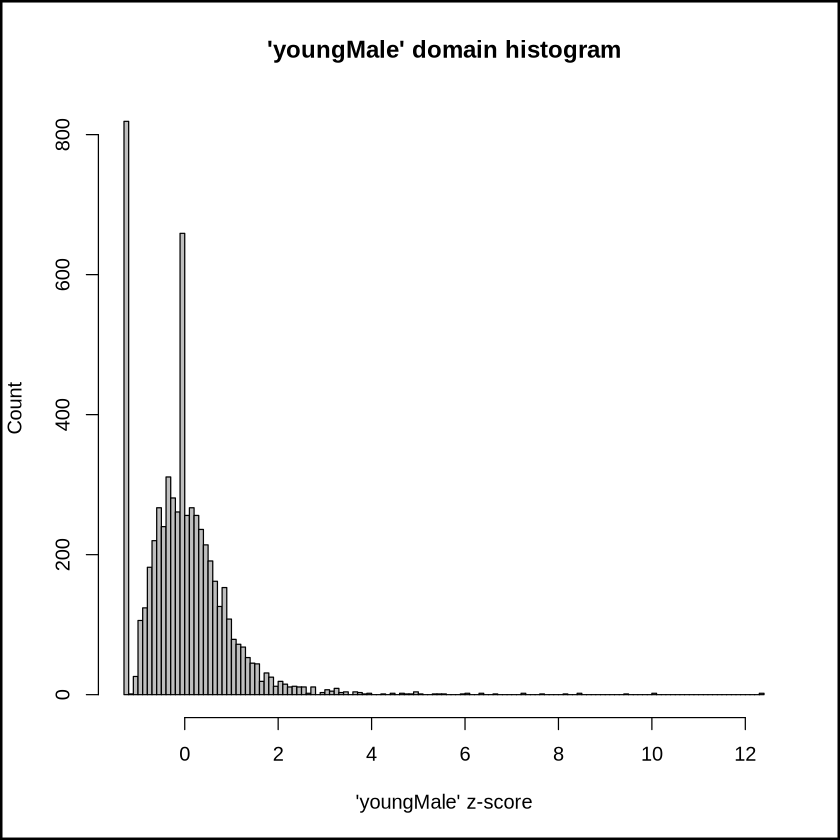

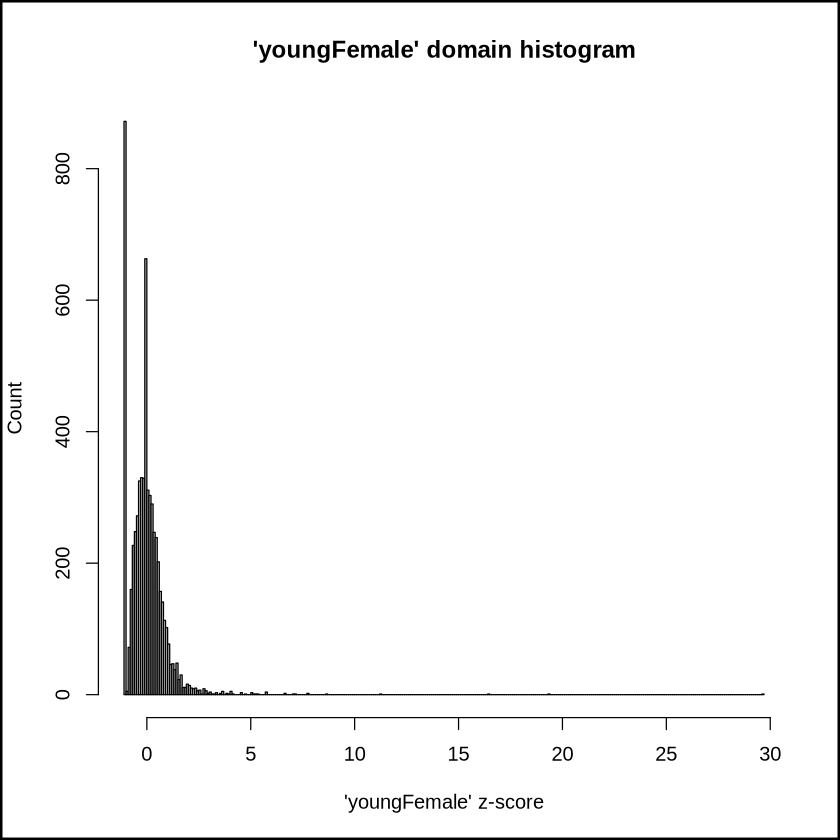

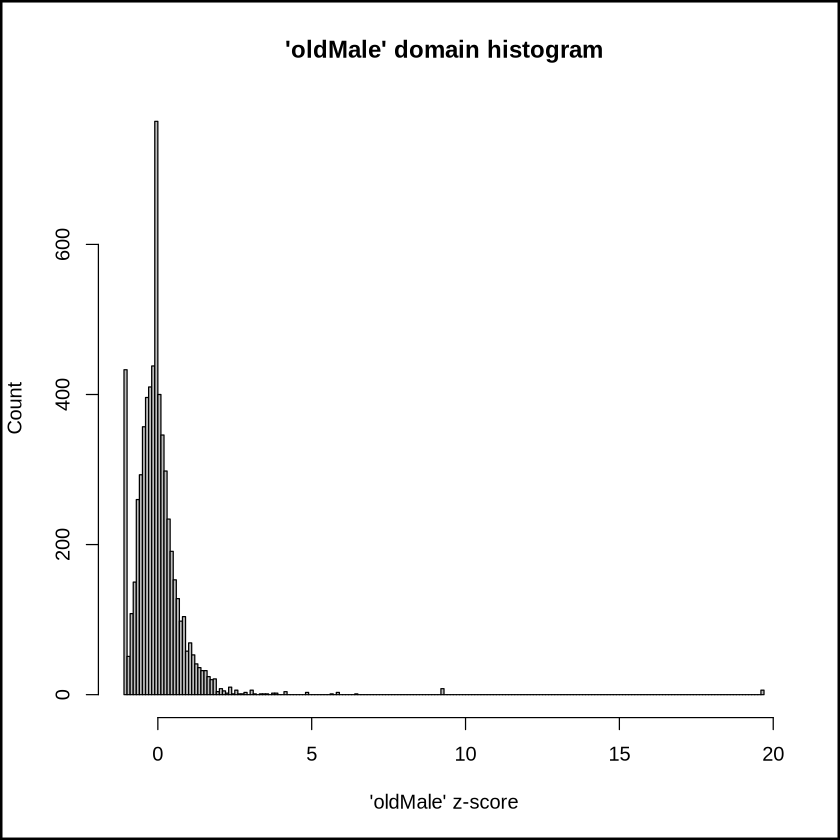

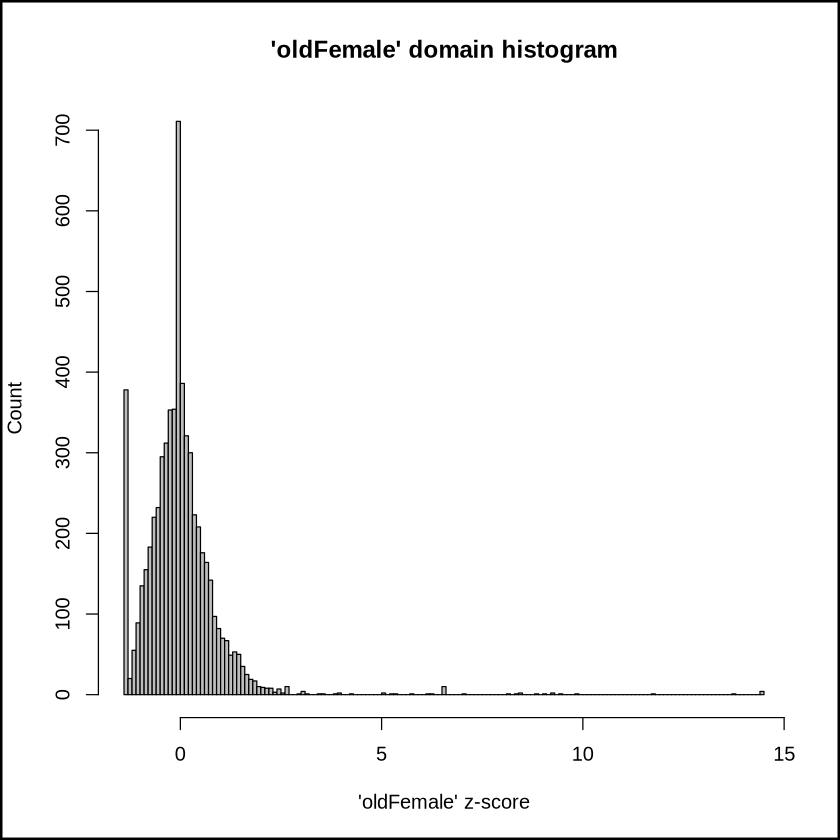

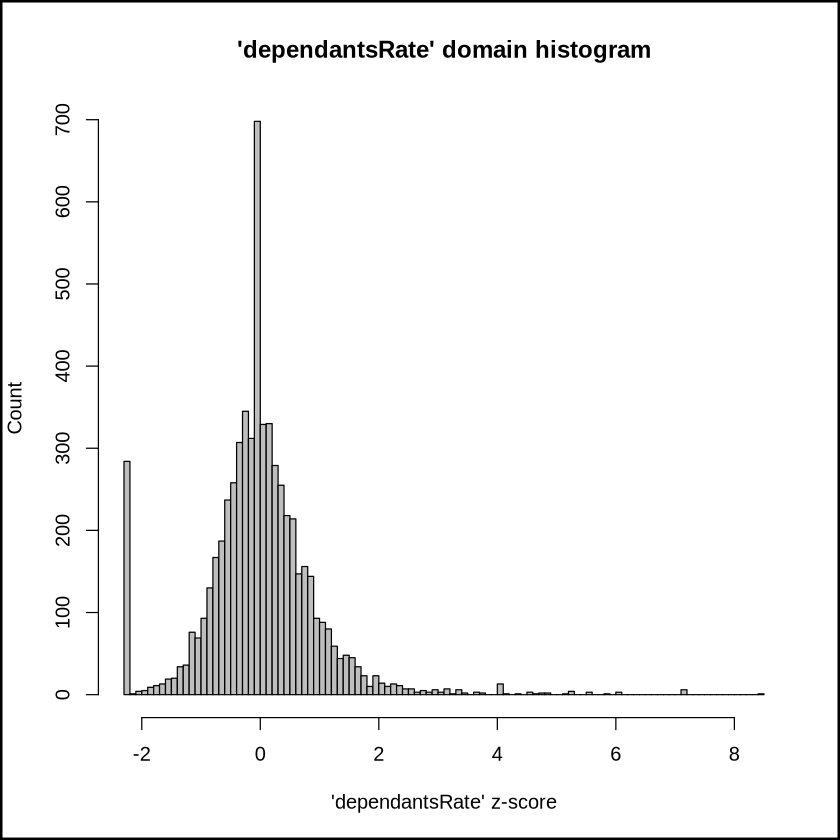

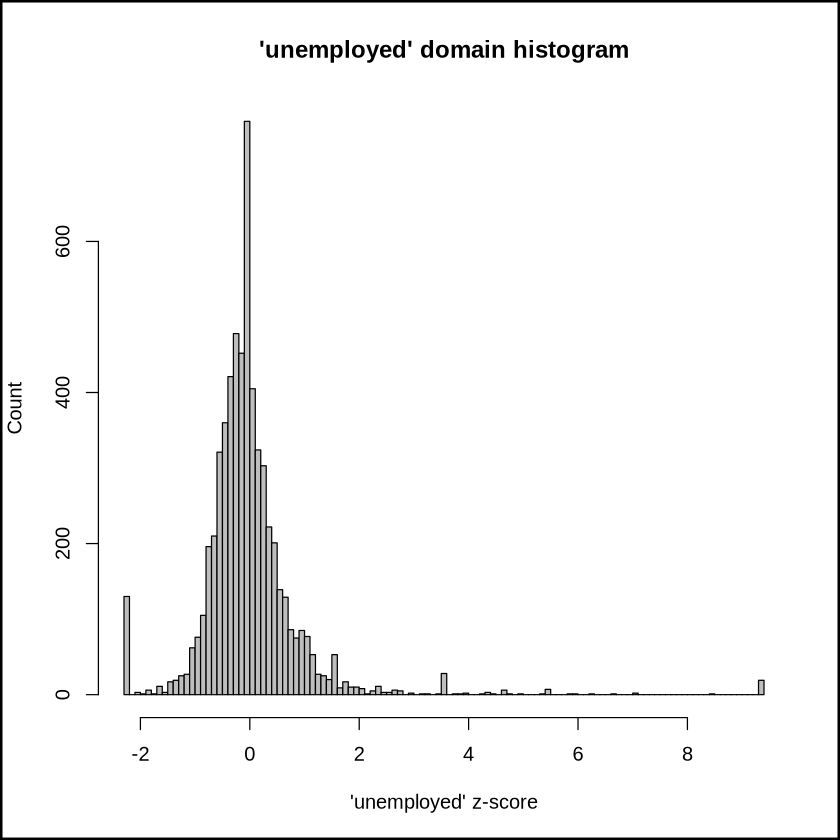

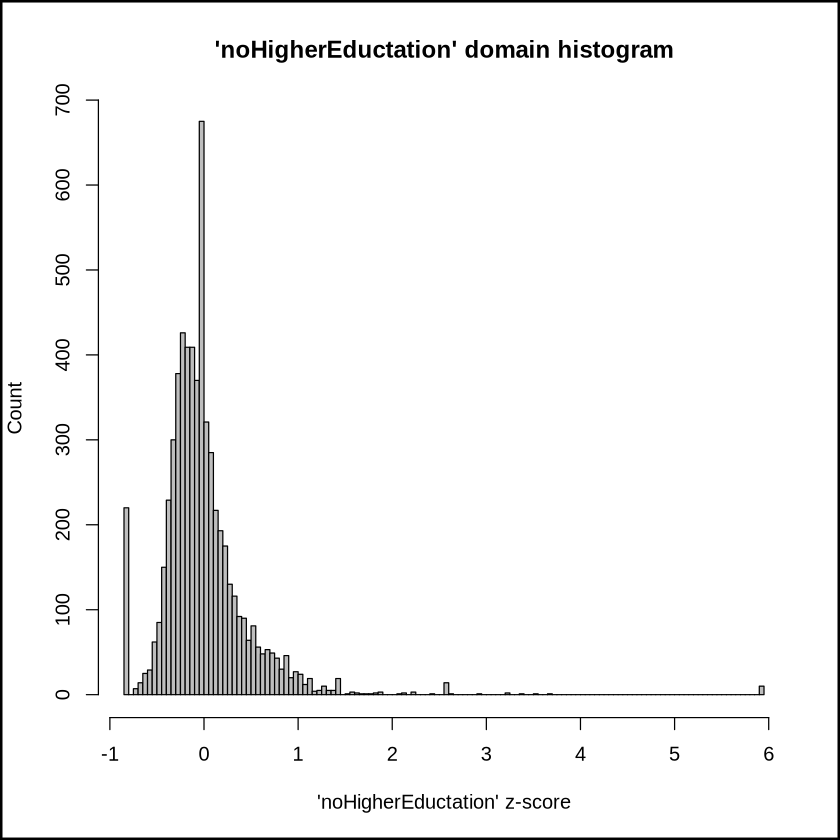

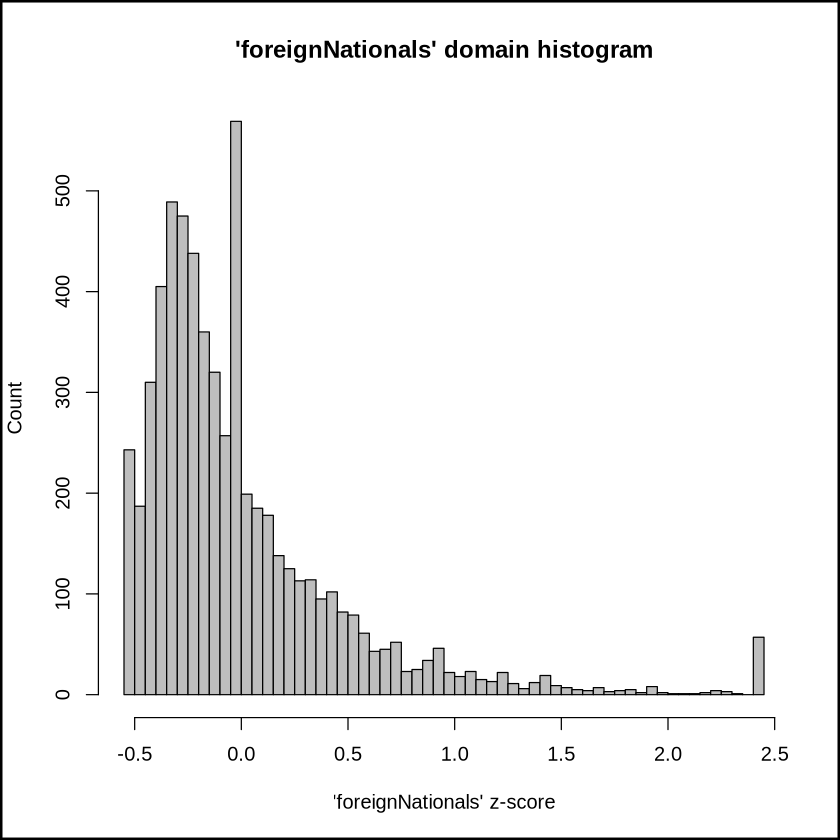

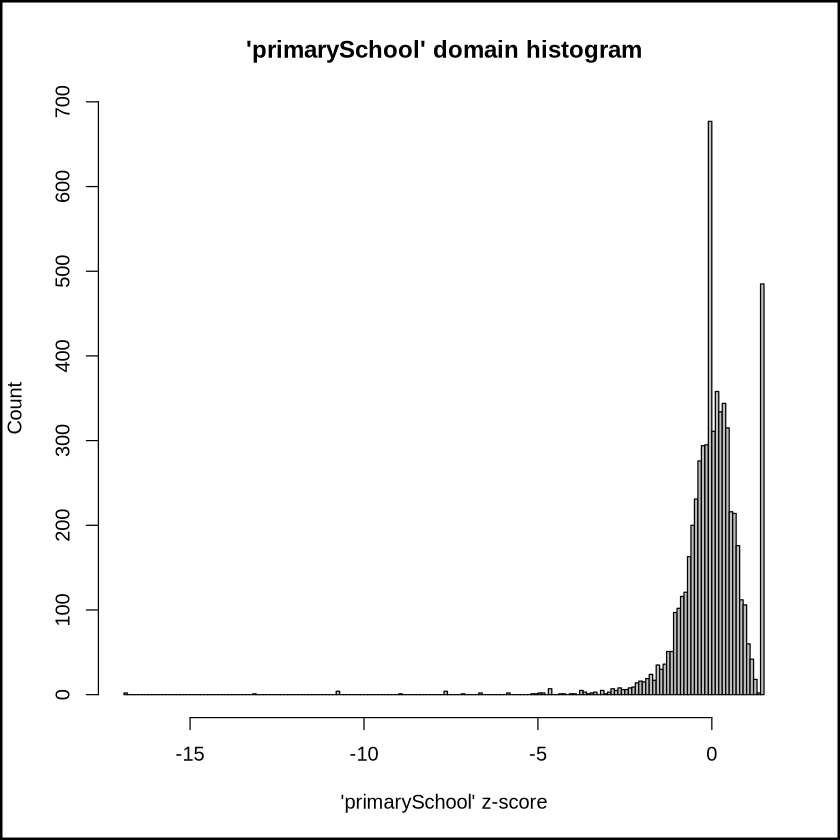

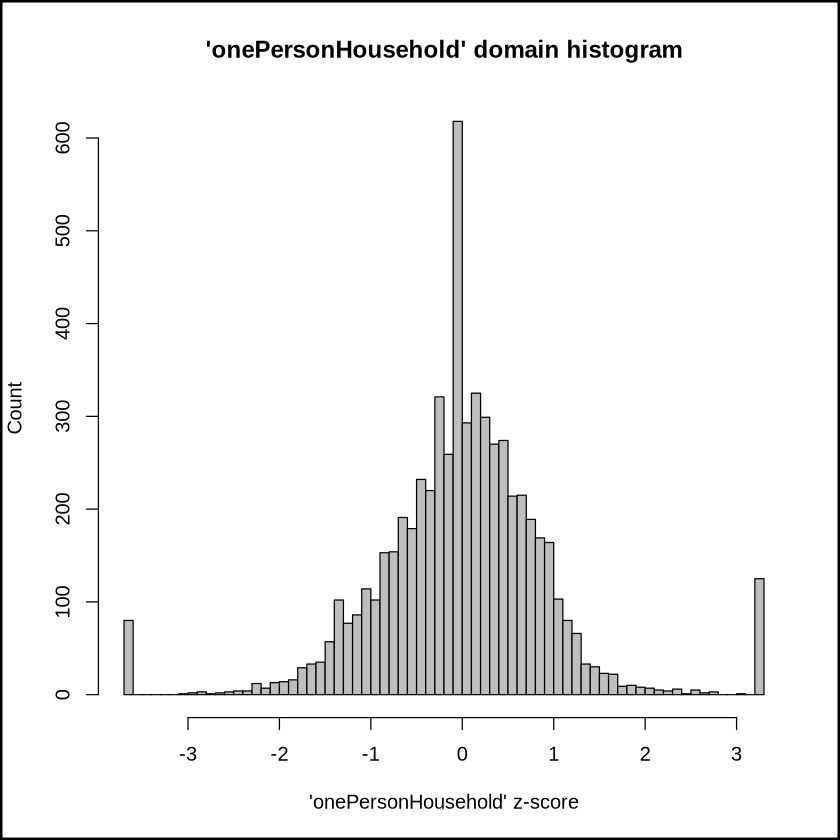

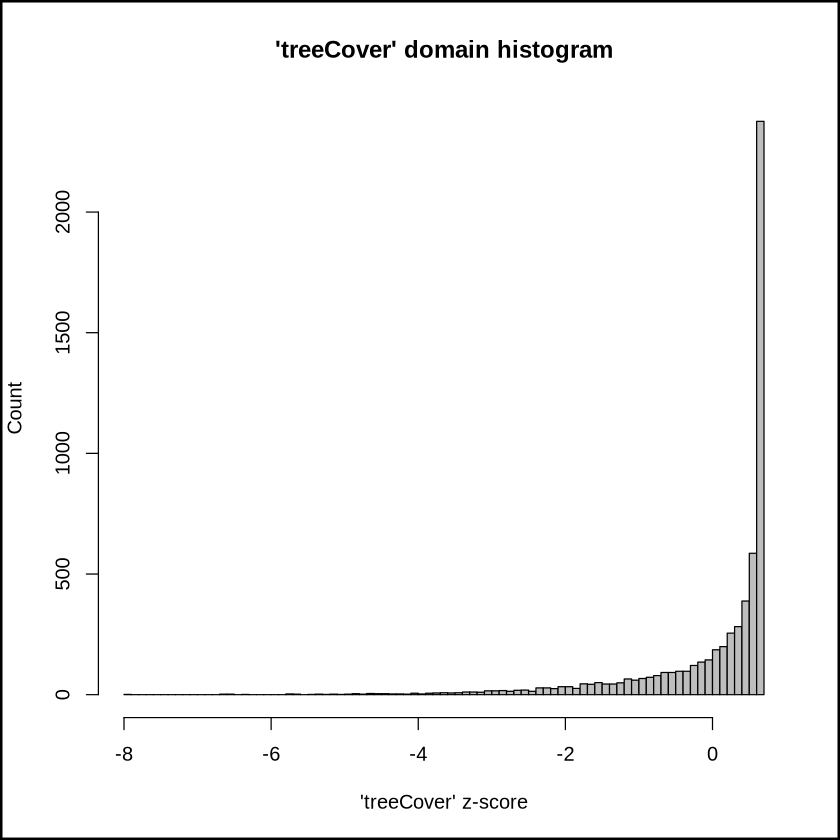

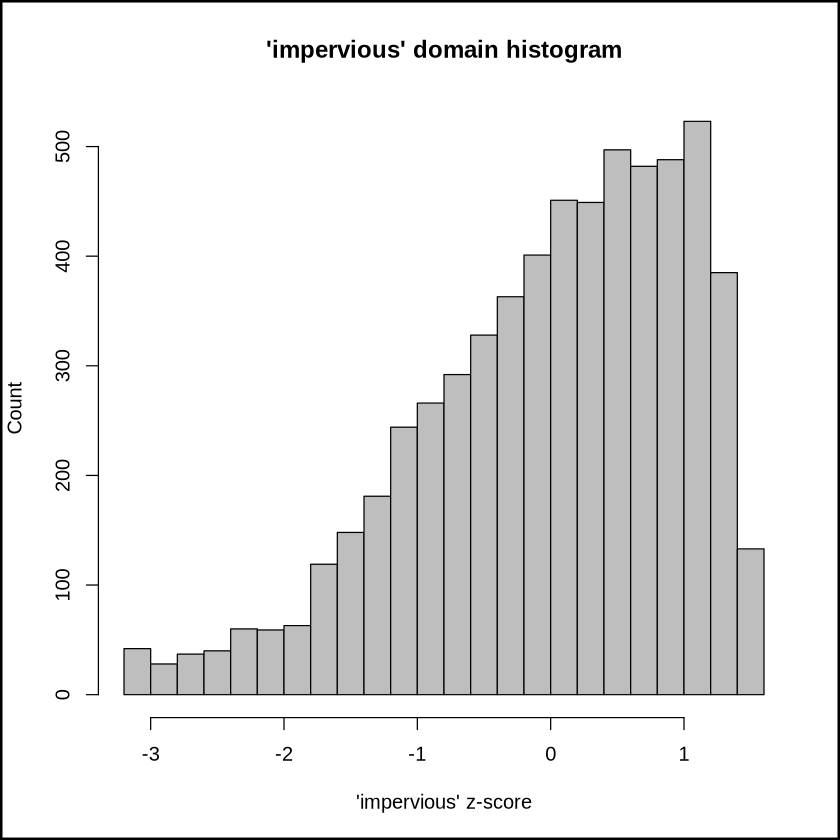

In [7]:
# Histogram visualisation of weighted indicators
indicatorColumns <- colnames(indicatorDataWeighted)[-1]
for (currentIndicatorColumn in indicatorColumns) {
    indicatorFiltered <- indicatorDataWeighted[,currentIndicatorColumn] 
    indicatorFiltered[indicatorFiltered == "NaN"] <- 0

    title <- paste("'", currentIndicatorColumn, "' domain histogram", sep = "")
    xLabel <- paste("'", currentIndicatorColumn, "' z-score", sep = "")
    yLabel <- paste("Count", sep = "")
    hist(indicatorFiltered, breaks="FD", col="grey", labels = FALSE, main=title, xlab=xLabel, ylab=yLabel)
    box("figure", lwd = 4)
}

## Process social vulnerability scores

### Calculate domain scores

In [8]:
# Get the domains and their associated indicator ID
domainIndicators <- indicatorMapping %>% select('domain', 'indicator')

# Get a vector/array of the unique domain names
uniqueDomains <- unique(domainIndicators$domain)

# Initialise the domain score dataset with the GUID
domainScores <- indicatorDataWeighted %>% select(all_of(GUID))

# Loop through each domain
for (currentDomain in uniqueDomains) {
    # Identify which indicators are used within this domain (currentDomain)
    currentDomainInfo <- domainIndicators %>% filter(domain == currentDomain)

    # Count the number of indicators in this domain
    domainIndicatorCount <- length(currentDomainInfo$indicator)

    # Get a vector/array of the indicators used by this domain, and add the GUID column name
    currentDomainIndicators <- currentDomainInfo$indicator
    currentDomainIndicators <- (c(GUID, currentDomainIndicators))

    # filter the dataset to only use the indicators in the domain
    currentDomainData <- indicatorDataWeighted[currentDomainIndicators]

    # Calculate the internal weight distribution for the indicators within this domain,
    # using an equal weight distribution across this domain
    internalDomainWeight <- 1.0/domainIndicatorCount

    # Internally weight the data for this domain
    currentDomainDataWeighted <- currentDomainData %>% mutate_if(is.numeric, function(x) {x*internalDomainWeight})

    # Sum each data row to get the total score for the domain
    currentDomainDataWeighted[, currentDomain] <- rowSums(currentDomainDataWeighted[2:(domainIndicatorCount+1)], na.rm = TRUE)

    # Add the current domain score to the overall results
    domainIndicatorScore <- currentDomainDataWeighted %>% select(all_of(GUID), all_of(currentDomain))
    domainScores <- merge(domainScores, domainIndicatorScore, by=GUID)
}

# Print the first part of the domain z-scores, which are now collated into one table
head(domainScores)

,SEZ2011,age,income,info,locKnow,socNet,physEnv
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,151460000001,-0.37028523,-0.6431147,-0.3037669,0.142430939,1.1958366,1.0118090
2,151460000002,-0.59583610,0.7308663,0.4424940,0.384372102,0.3778636,1.0418299
3,151460000003,0.05088688,-1.2312892,-0.8229049,-0.540697051,2.3409988,0.8359458
4,151460000004,-0.22564026,-0.8787686,-0.8229049,-0.002474999,-0.7933508,0.9203024
5,151460000005,4.00522505,-2.2590732,-0.8229049,-0.540697051,2.3409988,0.9671620
6,151460000006,0.00000000,0.0000000,0.0000000,0.000000000,0.0000000,1.0492594


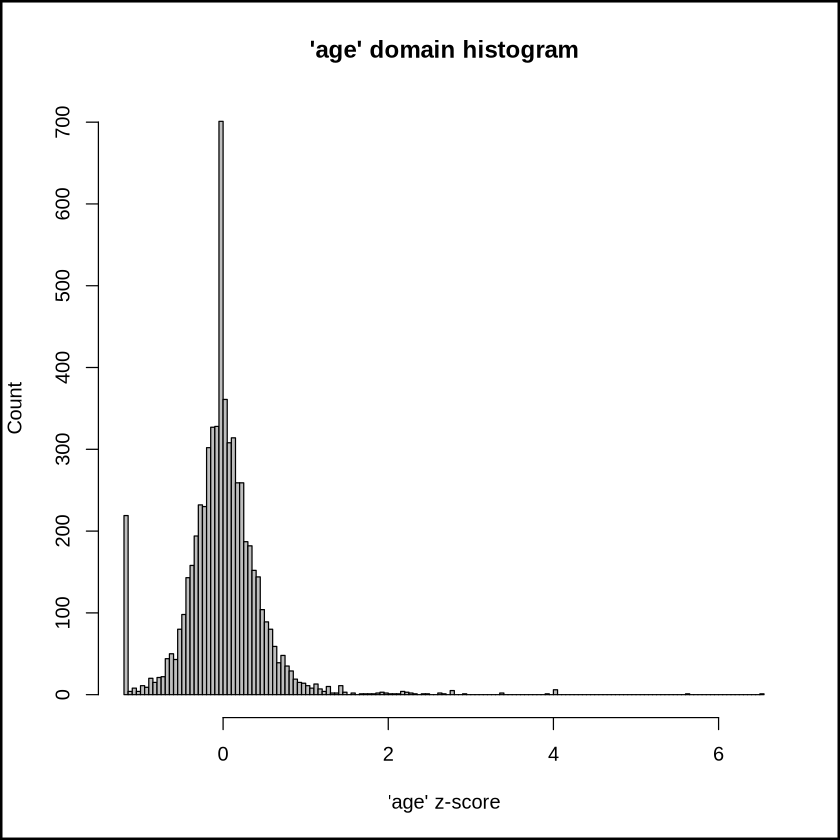

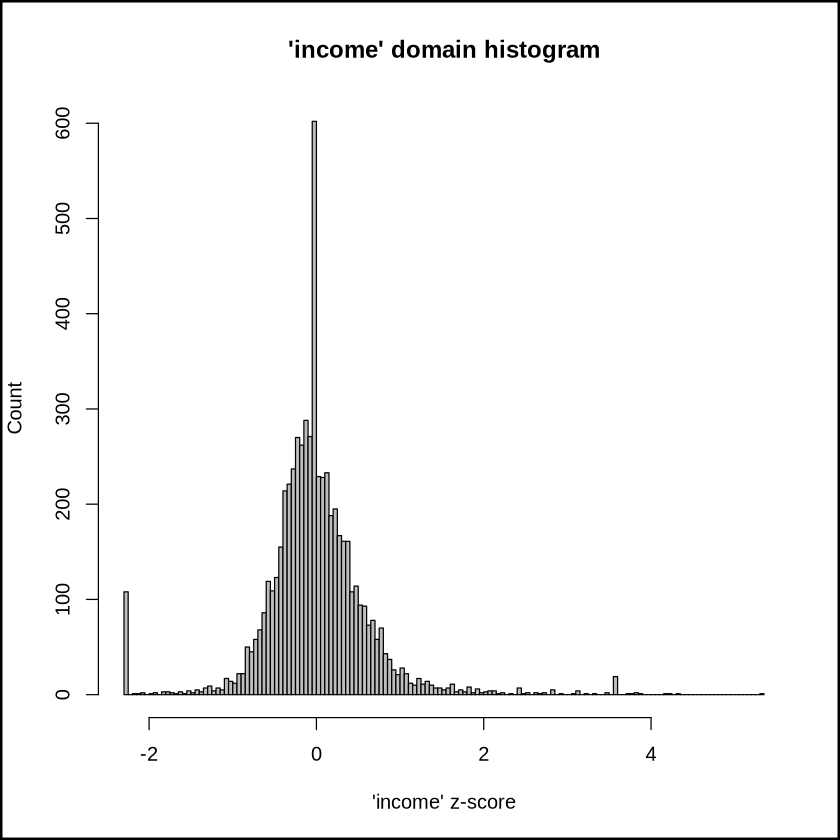

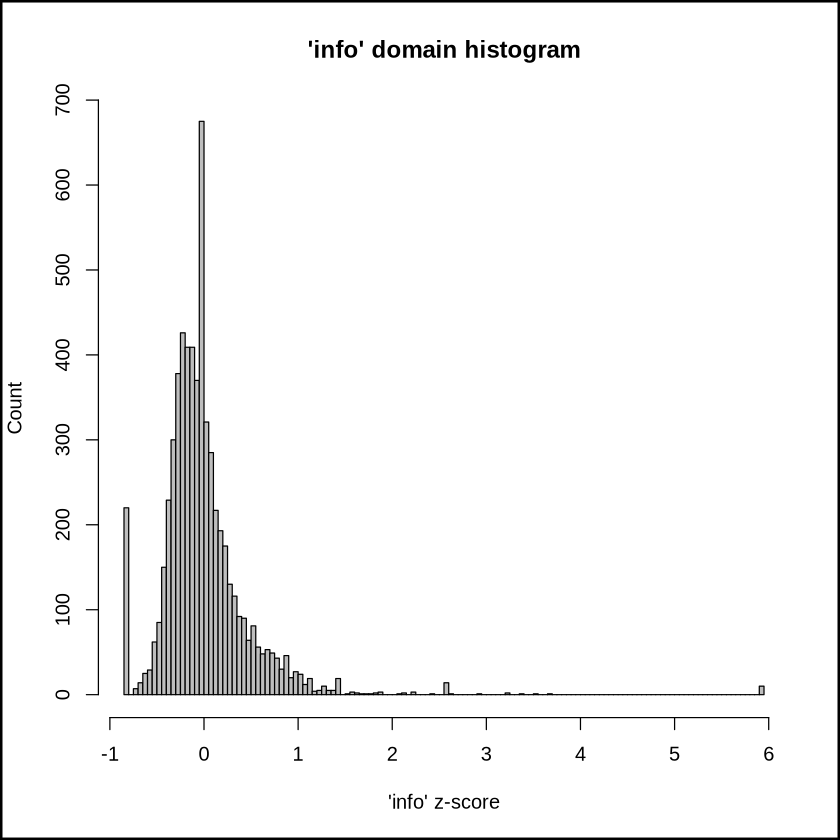

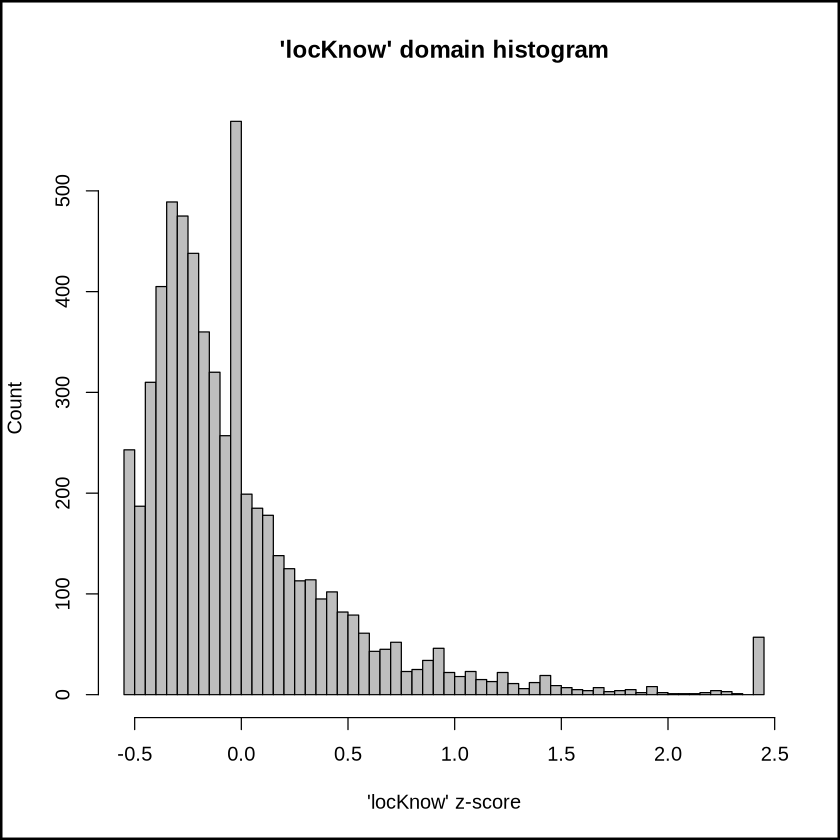

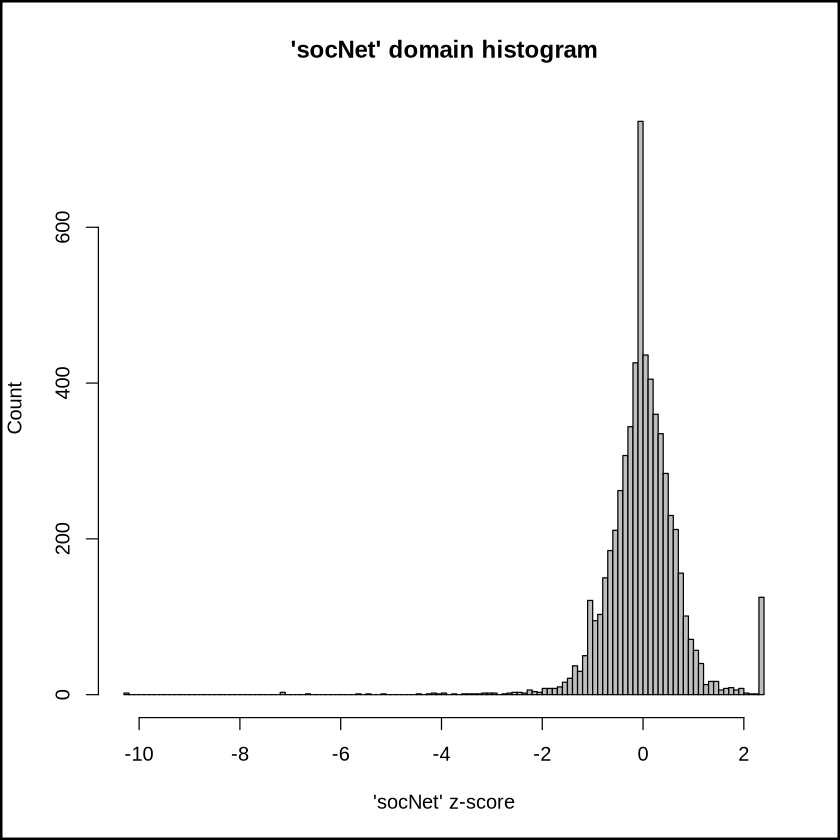

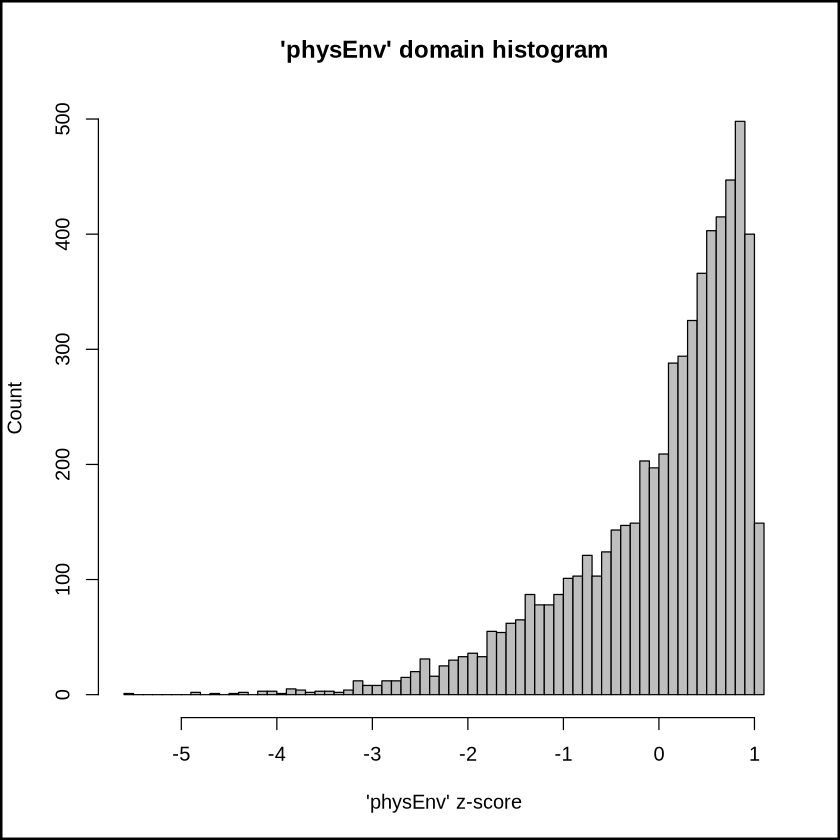

In [9]:
# Histogram visualisation of domain z-scores
for (currentDomain in uniqueDomains) {
    domainScoresFiltered <- domainScores[,currentDomain] 
    domainScoresFiltered[domainScoresFiltered == "NaN"] <- 0

    title <- paste("'", currentDomain, "' domain histogram", sep = "")
    xLabel <- paste("'", currentDomain, "' z-score", sep = "")
    yLabel <- paste("Count", sep = "")
    hist(domainScoresFiltered, breaks="FD", col="grey", labels = FALSE, main=title, xlab=xLabel, ylab=yLabel)
    box("figure", lwd = 4)
}

### Calculate dimension scores
Need to collate the domains into the dimensions

In [10]:
# Create a vector/array of the dimension names
dimensions <- c('sens', 'prepare', 'respond', 'recover', 'adaptiveCapacity', 'enhExp')

# Get the dimension and their associated indicator ID
dimensionIndicators <- indicatorMapping %>% select(c('domain', all_of(dimensions)))
head(dimensionIndicators)

# Initialise the dimensions score dataset with the GUID
dimensionScores <- indicatorDataWeighted %>% select(all_of(GUID))

# loop through each of the dimensions and:
for (currentDimension in dimensions){
    # Identify which indicators are used within this dimension (currentDimension)
    # Then select the indicators marked with value 1, which means that the indicator is part of the dimension
    currentDimensionInfo <- dimensionIndicators %>% select(c('domain', all_of(currentDimension)))
    currentDimensionInfo <- currentDimensionInfo %>% filter(dimensionIndicators[, currentDimension] == 1)

    # Get a array/vector of the unique domains in this dimension
    currentDimensionDomains <- unique(currentDimensionInfo$domain)

    # Count the number of domains in this dimension
    dimensionDomainCount <- length(currentDimensionDomains)

    # Filter the domain scores dataset to only use the domains in the dimension, and add the GUID column name
    currentDimensionData <- domainScores %>% select(c(all_of(GUID), all_of(currentDimensionDomains)))  

    # Sum each data row to get the total score for the dimension
    currentDimensionData[, currentDimension] <- rowSums(currentDimensionData[2:(dimensionDomainCount+1)], na.rm = TRUE)

    # Add the current dimension score to the overall results
    dimensionIndicatorScore <- currentDimensionData %>% select(all_of(GUID), all_of(currentDimension))
    dimensionScores <- merge(dimensionScores, dimensionIndicatorScore, by=GUID)  
}

# generate z-scores with the scale function in order to standardise the dimension data
dimensionScores <- dimensionScores %>% mutate_if(is.numeric, scale)

# Print the first part of the dimension scores, which are now collated into one table
head(dimensionScores)

,domain,sens,prepare,respond,recover,adaptiveCapacity,enhExp
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>
1,age,1,0,0,0,0,0
2,age,1,0,0,0,0,0
3,age,1,0,0,0,0,0
4,age,1,0,0,0,0,0
5,income,0,1,1,1,1,0
6,income,0,1,1,1,1,0


,SEZ2011,sens,prepare,respond,recover,adaptiveCapacity,enhExp
,<chr>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
1,151460000001,-0.7647853635,-0.696485479,0.320951976,0.271253971,0.320951976,1.0934219
2,151460000002,-1.2304165745,1.355476641,1.575888423,1.676990485,1.575888423,1.1258642
3,151460000003,0.1046897905,-2.251790899,-0.203447695,0.312110916,-0.203447695,0.9033735
4,151460000004,-0.4661777348,-1.478027752,-2.026764566,-2.690739562,-2.026764566,0.9945343
5,151460000005,8.2680954025,-3.144598085,-1.038699169,-0.797332495,-1.038699169,1.0451736
6,151460000006,-0.0003619911,0.002318221,0.002883523,0.002519028,0.002883523,1.1338930


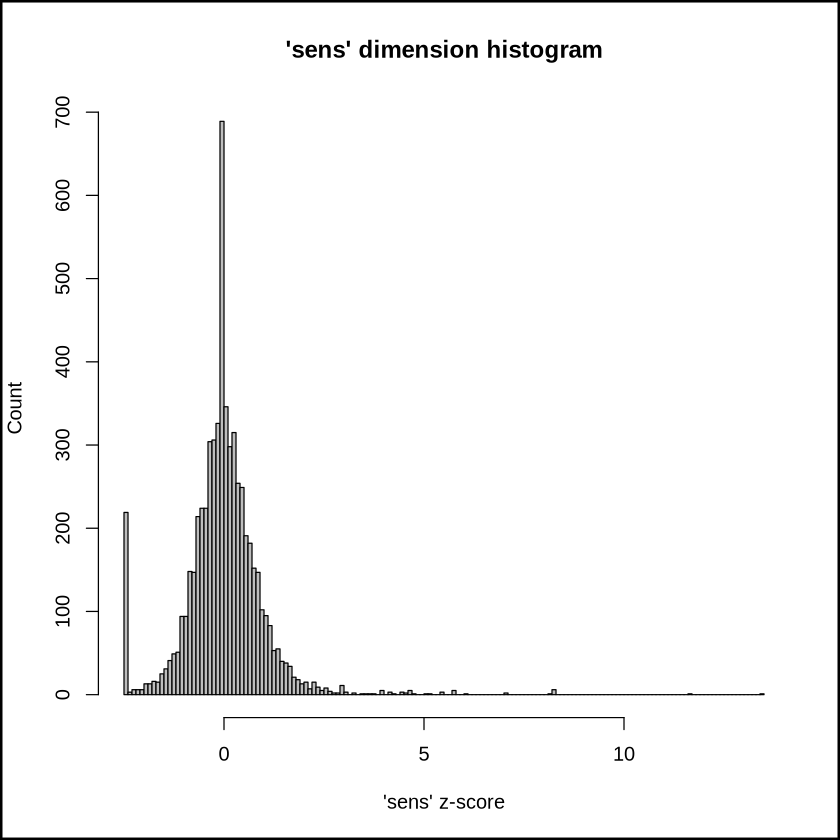

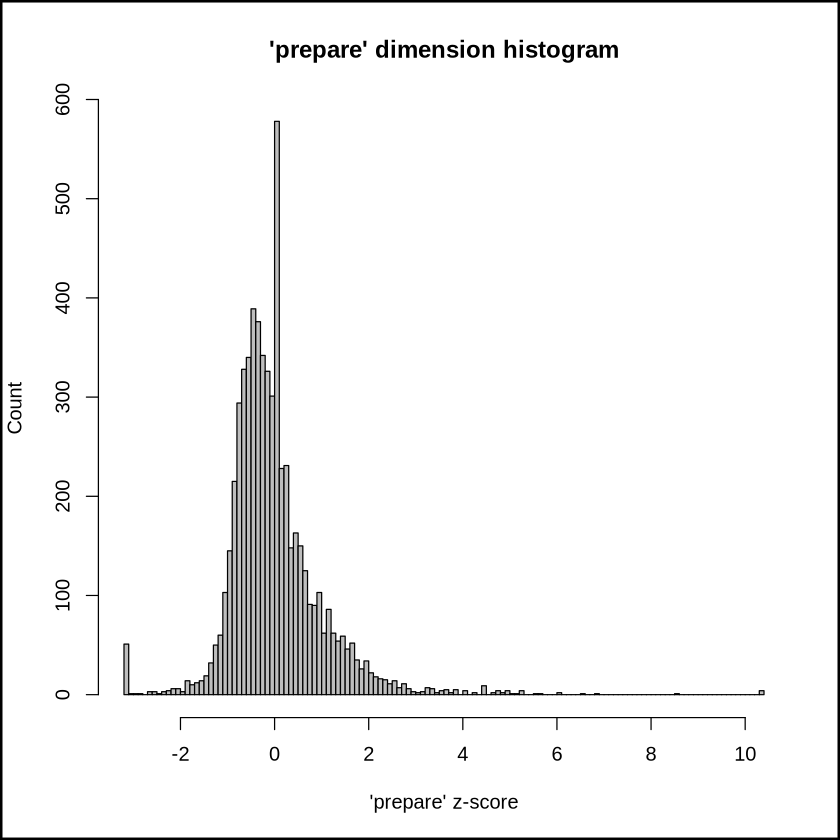

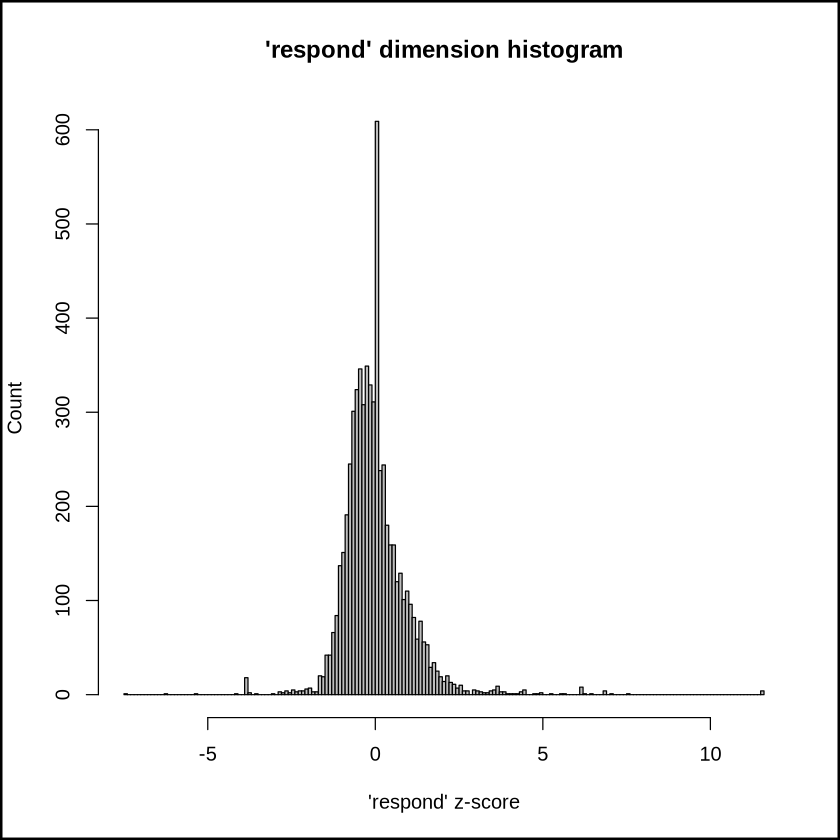

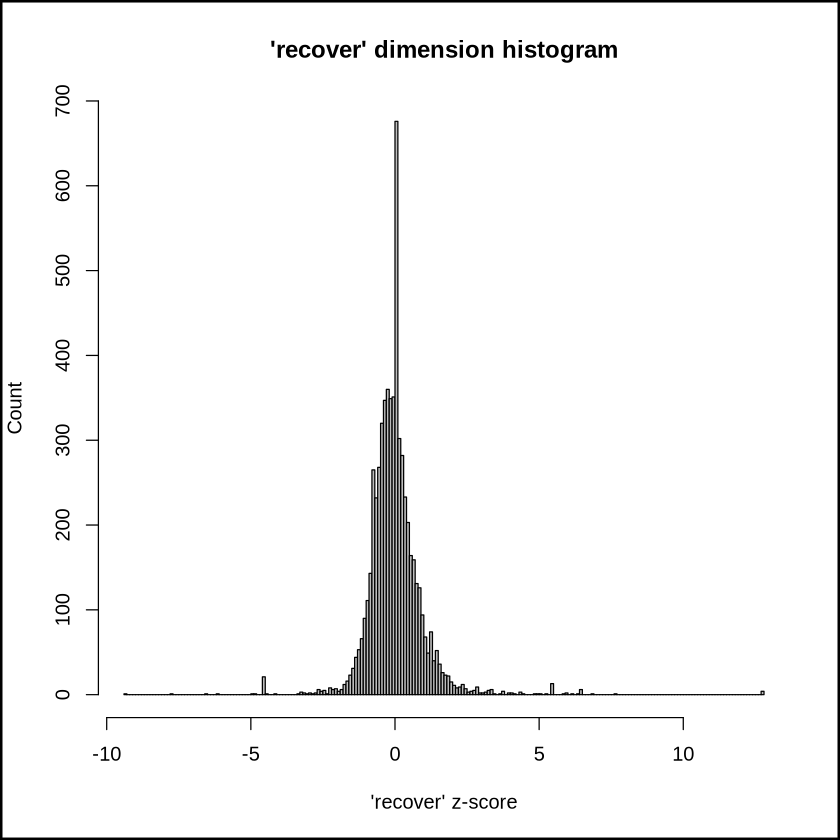

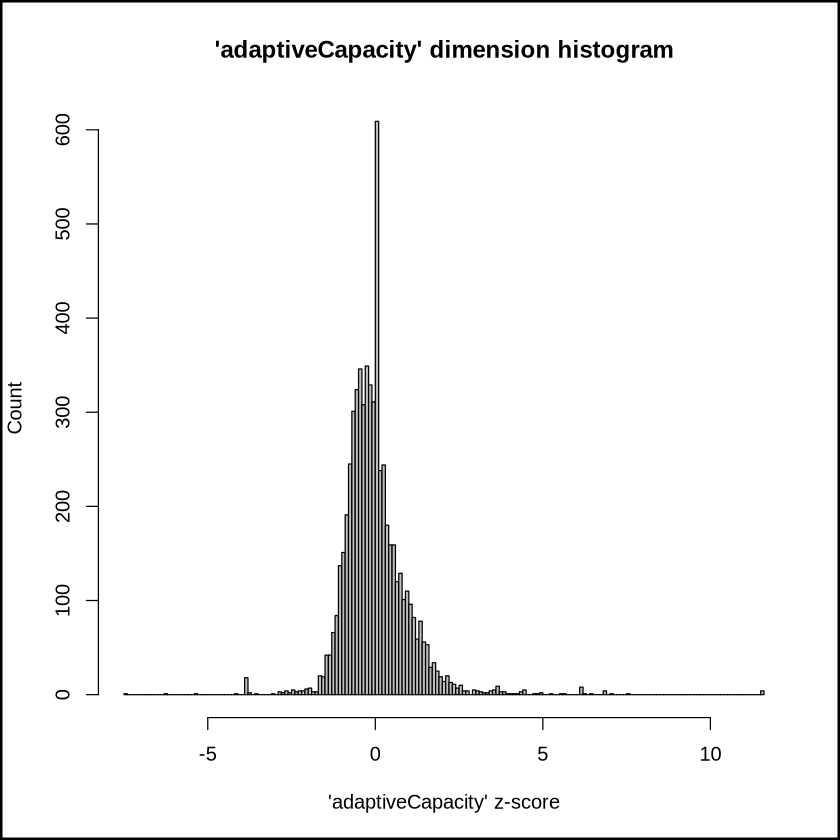

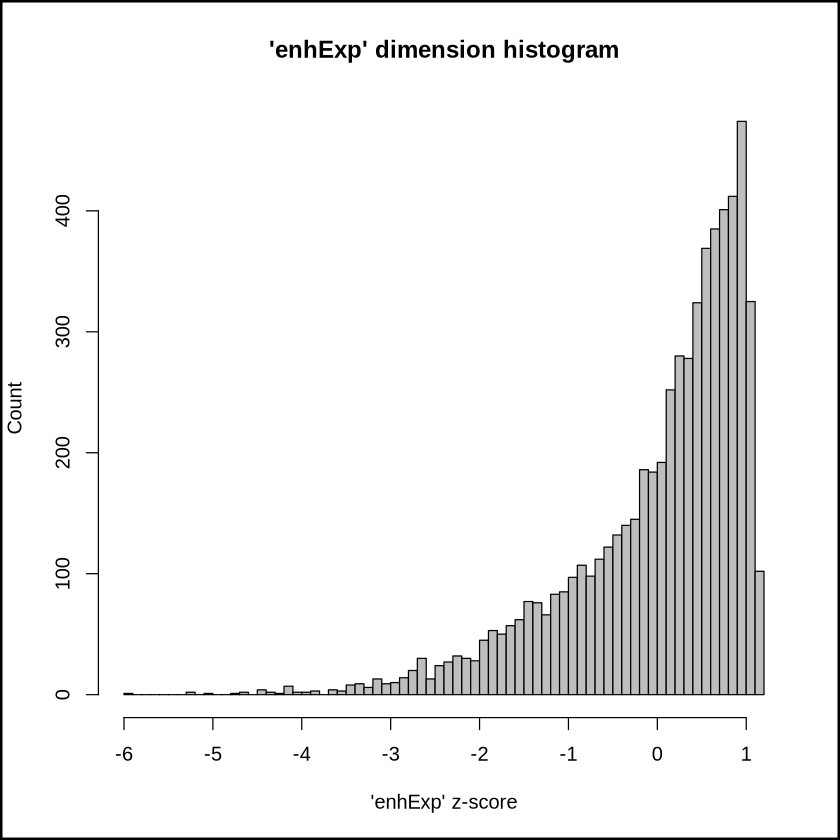

In [11]:
# Histogram visualisation of dimension z-scores
for (currentDimension in dimensions){
    dimensionScoresFiltered <- dimensionScores[,currentDimension] 
    dimensionScoresFiltered[dimensionScoresFiltered == "NaN"] <- 0
   
    title <- paste("'", currentDimension, "' dimension histogram", sep = "")
    xLabel <- paste("'", currentDimension, "' z-score", sep = "")
    yLabel <- paste("Count", sep = "")
    hist(dimensionScoresFiltered, breaks="FD", col="grey", labels = FALSE, main=title, xlab=xLabel, ylab=yLabel)
    box("figure", lwd = 4)
}

## Calculate vulnerability score

In [12]:
# Initialise the vulnerability score dataset with the GUID
vulnerabilityScores <- domainScores %>% select(all_of(GUID))

#sum the domains to create a total overall score of vulnerability
vulnerabilityScores$vulnerability <- rowSums(domainScores[2:(ncol(domainScores))], na.rm = TRUE)

# generate z-scores with the scale function in order to standardise the vulnerability data
vulnerabilityScores <- vulnerabilityScores %>% mutate_if(is.numeric, scale)

# Print the first part of the vulnerability scores, which are now collated into one table
head(vulnerabilityScores)

,SEZ2011,vulnerability
,<chr>,"<dbl[,1]>"
1,151460000001,0.6558794
2,151460000002,1.5094801
3,151460000003,0.4027326
4,151460000004,-1.1389091
5,151460000005,2.3380431
6,151460000006,0.6662274


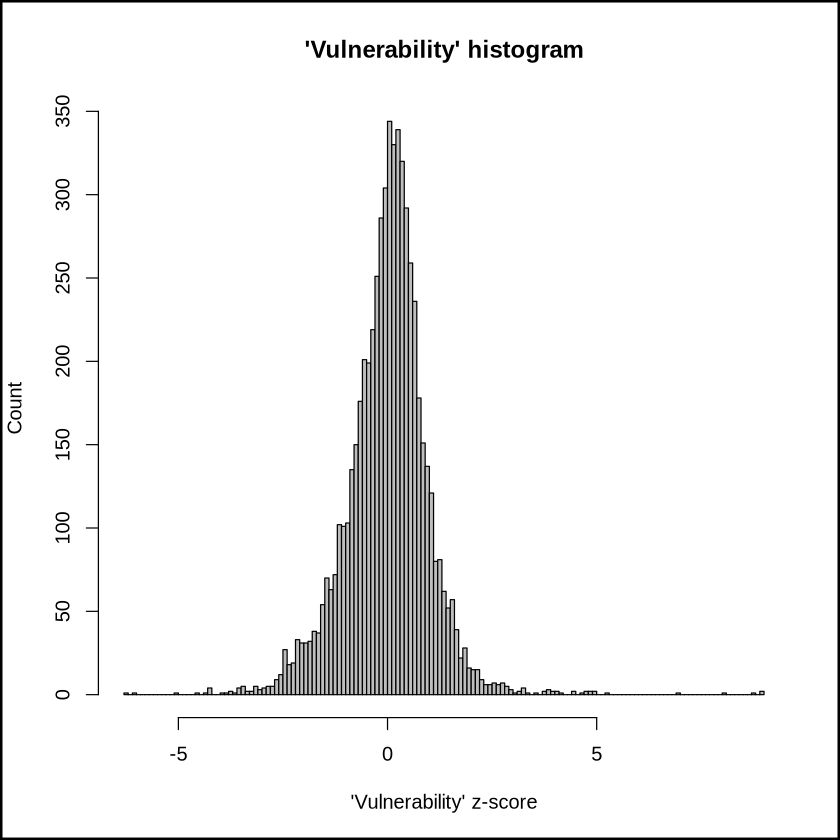

In [13]:
# Histogram visualisation of Vulnerability z-scores
title <- paste("'Vulnerability' histogram", sep = "")
xLabel <- paste("'Vulnerability' z-score", sep = "")
yLabel <- paste("Count", sep = "")
hist(vulnerabilityScores$vulnerability, breaks="FD", col="grey", labels = FALSE, main=title, xlab=xLabel, ylab=yLabel)
box("figure", lwd = 4)

In [14]:
# Merge all the indicators, domains, dimensions, and total vulnerability into one dataset
outputDataset <- merge(indicatorDataWeighted, domainScores, by=GUID)
outputDataset <- merge(outputDataset, dimensionScores, by=GUID)
outputDataset <- merge(outputDataset, vulnerabilityScores, by=GUID)

head(outputDataset)

,SEZ2011,youngMale,youngFemale,oldMale,oldFemale,dependantsRate,unemployed,noHigherEductation,foreignNationals,primarySchool,⋯,locKnow,socNet,physEnv,sens,prepare,respond,recover,adaptiveCapacity,enhExp,vulnerability
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
1,151460000001,-1.230411,-1.064144,2.1196292,-1.3062152,-0.7801407,-0.5060886,-0.3037669,0.142430939,1.458348,⋯,0.142430939,1.1958366,1.0118090,-0.7647853635,-0.696485479,0.320951976,0.271253971,0.320951976,1.0934219,0.6558794
2,151460000002,-1.230411,-1.064144,0.2302043,-0.3189938,0.1197864,1.3419462,0.4424940,0.384372102,1.458348,⋯,0.384372102,0.3778636,1.0418299,-1.2304165745,1.355476641,1.575888423,1.676990485,1.575888423,1.1258642,1.5094801
3,151460000003,-1.230411,-1.064144,3.8043177,-1.3062152,-2.2200240,-0.2425543,-0.8229049,-0.540697051,1.458348,⋯,-0.540697051,2.3409988,0.8359458,0.1046897905,-2.251790899,-0.203447695,0.312110916,-0.203447695,0.9033735,0.4027326
4,151460000004,-1.230411,-1.064144,2.6982091,-1.3062152,-0.5183437,-1.2391934,-0.8229049,-0.002474999,-1.865648,⋯,-0.002474999,-0.7933508,0.9203024,-0.4661777348,-1.478027752,-2.026764566,-2.690739562,-2.026764566,0.9945343,-1.1389091
5,151460000005,-1.230411,-1.064144,19.6216703,-1.3062152,-2.2200240,-2.2981224,-0.8229049,-0.540697051,1.458348,⋯,-0.540697051,2.3409988,0.9671620,8.2680954025,-3.144598085,-1.038699169,-0.797332495,-1.038699169,1.0451736,2.3380431
6,151460000006,0.000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000000,0.000000,⋯,0.000000000,0.0000000,1.0492594,-0.0003619911,0.002318221,0.002883523,0.002519028,0.002883523,1.1338930,0.6662274


## Correlations

In [15]:
# check the correlations
correlation <- cor(outputDataset %>% select(-c(all_of(GUID))), use="pairwise.complete.obs")
correlation

,youngMale,youngFemale,oldMale,oldFemale,dependantsRate,unemployed,noHigherEductation,foreignNationals,primarySchool,onePersonHousehold,⋯,locKnow,socNet,physEnv,sens,prepare,respond,recover,adaptiveCapacity,enhExp,vulnerability
youngMale,1.00000000,0.229097528,-0.14133786,-0.152371506,0.479381856,-0.06813950,-0.05906216,0.06968821,-0.211541089,-0.053140400,⋯,0.06968821,-0.17126794,0.041952673,0.468965905,0.177996543,0.06209890,0.046053168,0.06209890,0.041952673,0.21671079
youngFemale,0.22909753,1.000000000,-0.12233710,-0.115415283,0.447880059,-0.09983243,-0.07541606,0.02251899,-0.131044555,-0.087782855,⋯,0.02251899,-0.14149308,0.012169251,0.497075108,0.124612566,0.03031025,0.028487985,0.03031025,0.012169251,0.18312793
oldMale,-0.14133786,-0.122337104,1.00000000,0.291926773,-0.219142202,-0.20364703,0.01344422,-0.22114688,0.156731495,-0.058133618,⋯,-0.22114688,0.06398469,-0.130727845,0.515454373,-0.265588094,-0.20945491,-0.162603657,-0.20945491,-0.130727845,-0.08165958
oldFemale,-0.15237151,-0.115415283,0.29192677,1.000000000,-0.235062655,-0.23129506,0.23646828,-0.25730892,0.166348557,-0.001316863,⋯,-0.25730892,0.10686905,-0.133976721,0.513279034,-0.205041719,-0.12666491,-0.033731192,-0.12666491,-0.133976721,-0.01975176
dependantsRate,0.47938186,0.447880059,-0.21914220,-0.235062655,1.000000000,-0.08266693,0.11096832,0.08006488,-0.735608824,-0.291803934,⋯,0.08006488,-0.66460705,-0.024206633,0.237217276,0.467697674,0.03233285,0.001091004,0.03233285,-0.024206633,0.08373068
unemployed,-0.06813950,-0.099832433,-0.20364703,-0.231295057,-0.082666926,1.00000000,0.10782418,0.33788259,0.083462147,0.010301782,⋯,0.33788259,0.06069221,-0.046306921,-0.302233026,0.573835450,0.57384691,0.585589861,0.57384691,-0.046306921,0.32713626
noHigherEductation,-0.05906216,-0.075416063,0.01344422,0.236468283,0.110968315,0.10782418,1.00000000,0.26173870,-0.045445576,-0.029993040,⋯,0.26173870,-0.04877900,-0.128676167,0.057830642,0.624357416,0.55436679,0.599521006,0.55436679,-0.128676167,0.37411283
foreignNationals,0.06968821,0.022518991,-0.22114688,-0.257308923,0.080064879,0.33788259,0.26173870,1.00000000,-0.074132287,0.291800349,⋯,1.00000000,0.14025860,0.058567612,-0.193601159,0.707212143,0.74713737,0.469628941,0.74713737,0.058567612,0.55682335
primarySchool,-0.21154109,-0.131044555,0.15673150,0.166348557,-0.735608824,0.08346215,-0.04544558,-0.07413229,1.000000000,0.196787249,⋯,-0.07413229,0.77451044,0.003812838,-0.009809013,-0.325644138,0.16757171,0.261335750,0.16757171,0.003812838,0.12973201
onePersonHousehold,-0.05314040,-0.087782855,-0.05813362,-0.001316863,-0.291803934,0.01030178,-0.02999304,0.29180035,0.196787249,1.000000000,⋯,0.29180035,0.77260594,0.284224811,-0.100459534,-0.008700115,0.46292243,0.462342309,0.46292243,0.284224811,0.49619186


## Add geometry

In [16]:
#add st_drop_geometry
outputDatasetGeom <- merge(outputDataset, oa, by.x=GUID, by.y=GUID, all.x = TRUE)
head(outputDatasetGeom)

,SEZ2011,youngMale,youngFemale,oldMale,oldFemale,dependantsRate,unemployed,noHigherEductation,foreignNationals,primarySchool,⋯,socNet,physEnv,sens,prepare,respond,recover,adaptiveCapacity,enhExp,vulnerability,geometry
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<POLYGON [m]>
1,151460000001,-1.230411,-1.064144,2.1196292,-1.3062152,-0.7801407,-0.5060886,-0.3037669,0.142430939,1.458348,⋯,1.1958366,1.0118090,-0.7647853635,-0.696485479,0.320951976,0.271253971,0.320951976,1.0934219,0.6558794,"POLYGON ((1515164 5034507, ..."
2,151460000002,-1.230411,-1.064144,0.2302043,-0.3189938,0.1197864,1.3419462,0.4424940,0.384372102,1.458348,⋯,0.3778636,1.0418299,-1.2304165745,1.355476641,1.575888423,1.676990485,1.575888423,1.1258642,1.5094801,"POLYGON ((1515138 5034525, ..."
3,151460000003,-1.230411,-1.064144,3.8043177,-1.3062152,-2.2200240,-0.2425543,-0.8229049,-0.540697051,1.458348,⋯,2.3409988,0.8359458,0.1046897905,-2.251790899,-0.203447695,0.312110916,-0.203447695,0.9033735,0.4027326,"POLYGON ((1515050 5034427, ..."
4,151460000004,-1.230411,-1.064144,2.6982091,-1.3062152,-0.5183437,-1.2391934,-0.8229049,-0.002474999,-1.865648,⋯,-0.7933508,0.9203024,-0.4661777348,-1.478027752,-2.026764566,-2.690739562,-2.026764566,0.9945343,-1.1389091,"POLYGON ((1515095 5034409, ..."
5,151460000005,-1.230411,-1.064144,19.6216703,-1.3062152,-2.2200240,-2.2981224,-0.8229049,-0.540697051,1.458348,⋯,2.3409988,0.9671620,8.2680954025,-3.144598085,-1.038699169,-0.797332495,-1.038699169,1.0451736,2.3380431,"POLYGON ((1514881 5034455, ..."
6,151460000006,0.000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000000,0.000000,⋯,0.0000000,1.0492594,-0.0003619911,0.002318221,0.002883523,0.002519028,0.002883523,1.1338930,0.6662274,"POLYGON ((1514764 5034456, ..."


# Export

In [17]:
# create the output directory if it does not exist
outputDir <- file.path("../..","3_outputs","Milan","2021")
if(!dir.exists(outputDir)){
    dir.create(outputDir, recursive = TRUE)
    print(paste0(outputDir, " created"))
}

# CSV
write.csv(outputDataset, file.path(outputDir,"milan_vulnerability_2021.csv"), row.names = FALSE)

# GeoJSON
st_write(outputDatasetGeom, file.path(outputDir,"milan_vulnerability_2021.geojson"), delete_dsn=TRUE)

# Shapefile
st_write(outputDatasetGeom, file.path(outputDir,"milan_vulnerability_2021.shp"), append = FALSE)

Deleting source `../../3_outputs/Milan/2021/milan_vulnerability_2021.geojson' using driver `GeoJSON'
Writing layer `milan_vulnerability_2021' to data source 
  `../../3_outputs/Milan/2021/milan_vulnerability_2021.geojson' using driver `GeoJSON'
Writing 6079 features with 26 fields and geometry type Polygon.


Warning message in abbreviate_shapefile_names(obj):
“Field names abbreviated for ESRI Shapefile driver”


Deleting layer `milan_vulnerability_2021' using driver `ESRI Shapefile'
Writing layer `milan_vulnerability_2021' to data source 
  `../../3_outputs/Milan/2021/milan_vulnerability_2021.shp' using driver `ESRI Shapefile'
Writing 6079 features with 26 fields and geometry type Polygon.


**END**